# Environment

In [50]:
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy import stats
import seaborn as sns
import gc
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

cluster = True

In [51]:
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [52]:
if cluster:
    wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_microglia/GSE98969'
else:
    wd_dir = '/home/michal/WSL_GitHub/SRF_microglia/GSE98969'
os.chdir(wd_dir)

In [53]:
if cluster:
    sharon_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_microglia/Sharon_RNA/samples/all/runs/all/fastq/merge-by-read/trimmed/trimmomatic/mapped/STAR/merged/featureCounts/merged'
else:
    sharon_dir = '/home/michal/WSL_GitHub/SRF_microglia/data/sharon_rna'

In [54]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [55]:
%%R
x <- c(1, 2, 3, 4, 5)
mean(x)

[1] 3


# Load GSE98969 data

In [56]:
# Get list of all MARS-seq files
mars_seq_files = glob('./data/extracted/GSM*.txt.gz')
print(mars_seq_files)

['./data/extracted/GSM2629411_AB2327.txt.gz', './data/extracted/GSM2629371_AB1714.txt.gz', './data/extracted/GSM2629398_AB1741.txt.gz', './data/extracted/GSM2629374_AB1717.txt.gz', './data/extracted/GSM2629412_AB2328.txt.gz', './data/extracted/GSM2629354_AB1549.txt.gz', './data/extracted/GSM2629353_AB1548.txt.gz', './data/extracted/GSM2629434_AB2429.txt.gz', './data/extracted/GSM2629444_AB2439.txt.gz', './data/extracted/GSM2629449_AB2444.txt.gz', './data/extracted/GSM2629397_AB1740.txt.gz', './data/extracted/GSM2629415_AB2331.txt.gz', './data/extracted/GSM2629356_AB1551.txt.gz', './data/extracted/GSM2629430_AB2425.txt.gz', './data/extracted/GSM2629364_AB1667.txt.gz', './data/extracted/GSM2629405_AB1864.txt.gz', './data/extracted/GSM2629368_AB1711.txt.gz', './data/extracted/GSM2629343_AB1444.txt.gz', './data/extracted/GSM2629393_AB1736.txt.gz', './data/extracted/GSM2629359_AB1554.txt.gz', './data/extracted/GSM2629422_AB2338.txt.gz', './data/extracted/GSM2629409_AB2325.txt.gz', './data/e

In [57]:
# Read metadata
metadata = pd.read_csv('./data/metadata_csv.csv')
metadata_dict = metadata.set_index('geo_accession').to_dict('index')
metadata_dict[list(metadata_dict.keys())[0]]

{'Treatment': "treatment: Alzheimer's disease",
 'age': 'mouse age: 6 months',
 'region': 'Whole brain',
 'title': 'AB1442',
 'strain': 'strain: 5XFAD',
 'organ': 'organ: Brain'}

In [58]:
# def read_mars_seq_file_in_chunks(filename, chunksize=10000):
#     total_rows = sum(1 for _ in pd.read_csv(filename, sep='\t', compression='gzip', chunksize=chunksize))
    
#     pbar = tqdm(total=total_rows, desc="Reading file", unit="rows")
#     for chunk in pd.read_csv(filename, sep='\t', compression='gzip', index_col=0, chunksize=chunksize):
#         pbar.update(len(chunk))
#         yield chunk
#     pbar.close()

# def process_mars_seq_files(mars_seq_files, metadata_dict, chunksize=10000):
#     adata = None
#     obs_names_counter = {}
    
#     for file in tqdm(mars_seq_files, desc="Processing files", unit="file"):
#         print(f"\nProcessing file: {file}")
#         gsm_id = os.path.basename(file).split('_')[0]
        
#         for i, chunk in enumerate(read_mars_seq_file_in_chunks(file, chunksize)):
#             # Make observation names unique within the file
#             chunk.index = [f"{gsm_id}_{idx}" for idx in chunk.index]
            
#             # Ensure observation names are unique across all files
#             new_obs_names = []
#             for name in chunk.index:
#                 if name in obs_names_counter:
#                     obs_names_counter[name] += 1
#                     new_name = f"{name}_{obs_names_counter[name]}"
#                 else:
#                     obs_names_counter[name] = 0
#                     new_name = name
#                 new_obs_names.append(new_name)
            
#             chunk.index = new_obs_names
            
#             current_adata = ad.AnnData(chunk.T)
            
#             # Add metadata
#             if gsm_id in metadata_dict:
#                 for key, value in metadata_dict[gsm_id].items():
#                     current_adata.obs[key] = value
#             else:
#                 print(f"Warning: No metadata found for {gsm_id}")
            
#             if adata is None:
#                 adata = current_adata
#             else:
#                 adata = ad.concat([adata, current_adata], join='outer', fill_value=0)
            
#             # Clear temporary variables
#             del chunk, current_adata
#             gc.collect()
        
#         gc.collect()
    
#     return adata

In [59]:
# adata = process_mars_seq_files(mars_seq_files, metadata_dict)
# print(adata)

In [60]:
# Function to read a single MARS-seq file
def read_mars_seq_file(filename):
    df = pd.read_csv(filename, sep='\t', compression='gzip', index_col=0)
    return df


In [61]:
# Read all MARS-seq files and store them in a list
adatas = []
for file in mars_seq_files:
    df = read_mars_seq_file(file)
    adata = ad.AnnData(df.T)
    adata.var_names_make_unique()
    
    # Extract GSM ID from filename
    gsm_id = os.path.basename(file).split('_')[0]
    
    # Add metadata
    if gsm_id in metadata_dict:
        for key, value in metadata_dict[gsm_id].items():
            adata.obs[key] = value
    else:
        print(f"Warning: No metadata found for {gsm_id}")
    
    adatas.append(adata)

In [62]:
gc.collect()

10120

In [63]:
# Concatenate all AnnData objects
adata = ad.concat(adatas, join='outer', fill_value=0)
adata

AnnData object with n_obs × n_vars = 37248 × 34016
    obs: 'Treatment', 'age', 'region', 'title', 'strain', 'organ'

In [64]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [65]:
adata.obs.head()

,Treatment,age,region,title,strain,organ
W620561,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620562,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620563,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620564,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain
W620565,treatment: Alzheimer's disease,mouse age: 6 months,Whole brain,AB2327,strain: 5XFAD,organ: Brain


In [66]:
# Remove prefixes
adata.obs['Treatment'] = adata.obs['Treatment'].str.replace('treatment: ', '')
adata.obs['age'] = adata.obs['age'].str.replace('mouse age: ', '')
adata.obs['strain'] = adata.obs['strain'].str.replace('strain: ', '')
adata.obs['organ'] = adata.obs['organ'].str.replace('organ: ', '')


In [67]:
# Basic preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


In [68]:
# Calculate quality control metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # Identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

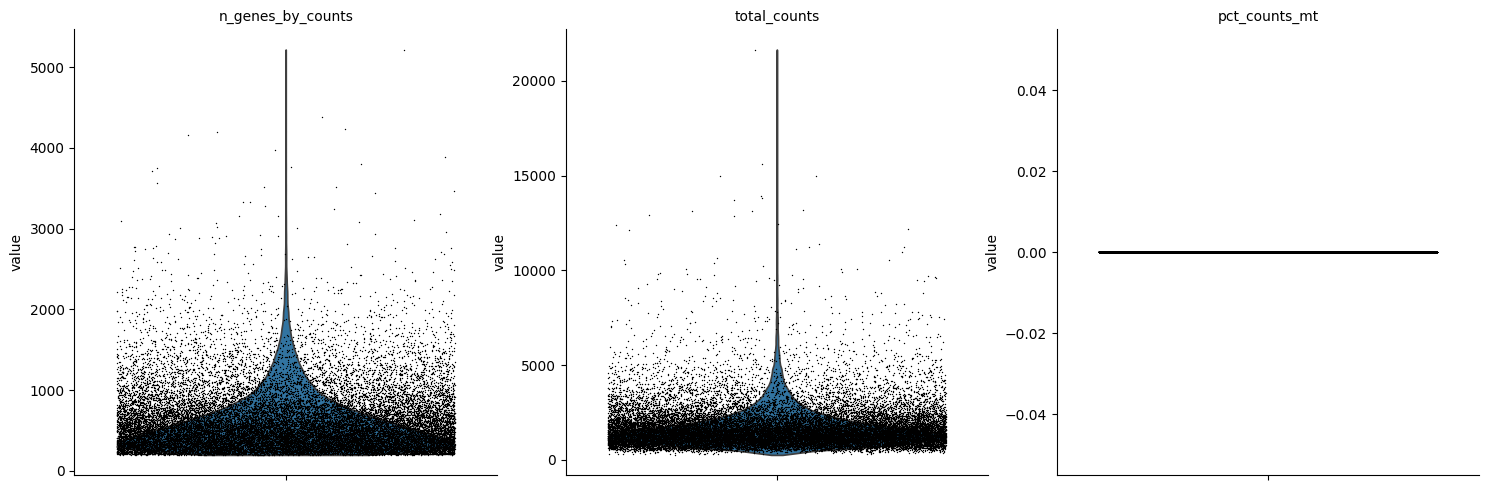

In [69]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [70]:
# Filter cells based on QC metrics (adjust these thresholds as needed)
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.total_counts < 10000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

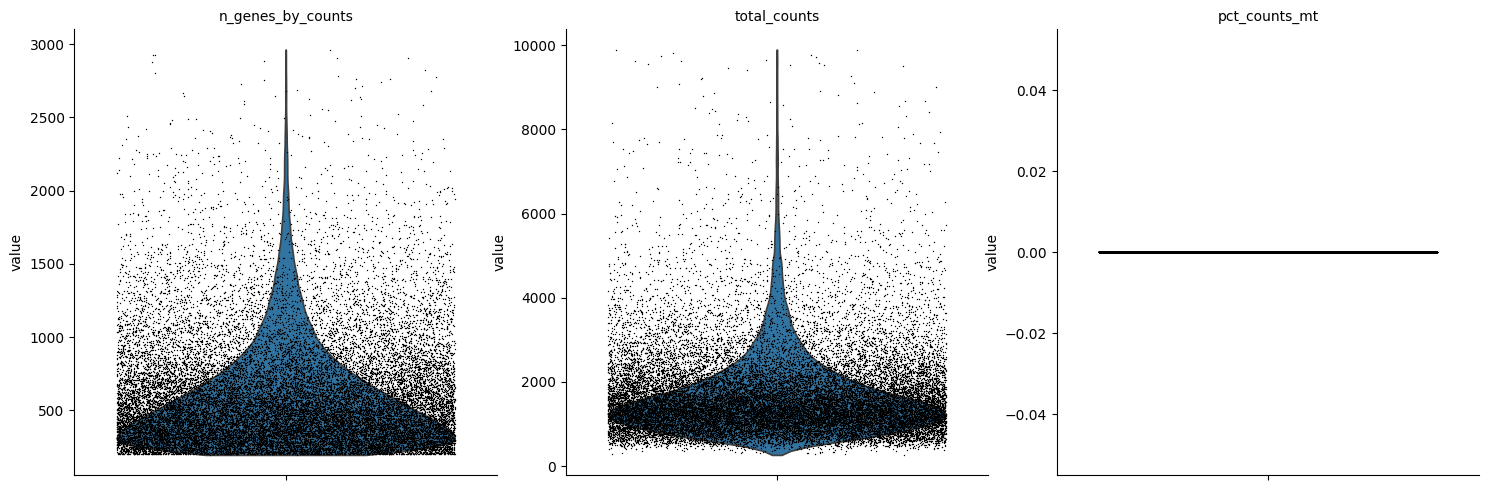

In [71]:
# Plot QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [72]:
# Save raw counts in a new layer
adata.layers['counts'] = adata.X.copy()

# Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/beegfs/scratch/tmp/ipykernel_21326/3388615946.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


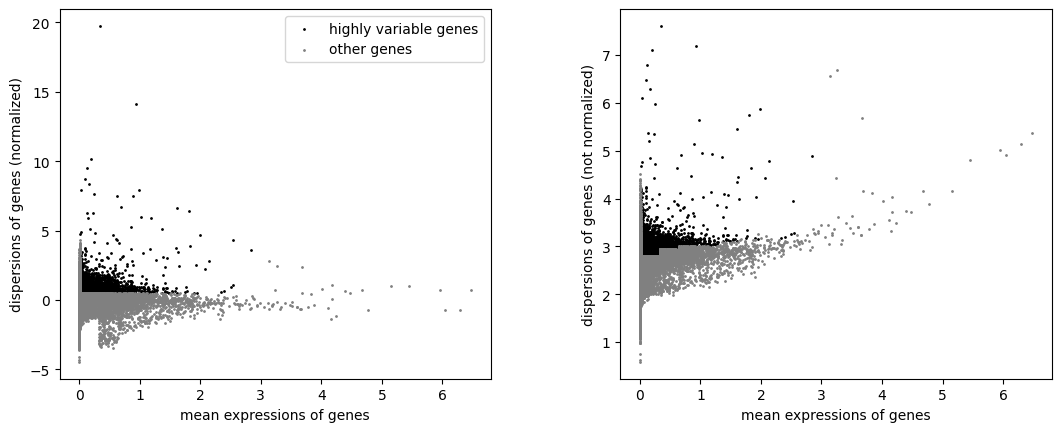

In [73]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [74]:
# Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression
adata.raw = adata

# Scale data
sc.pp.scale(adata, max_value=10)

In [75]:
# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

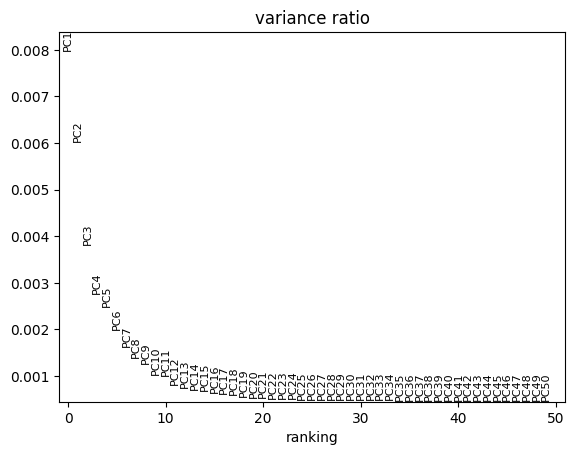

In [78]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

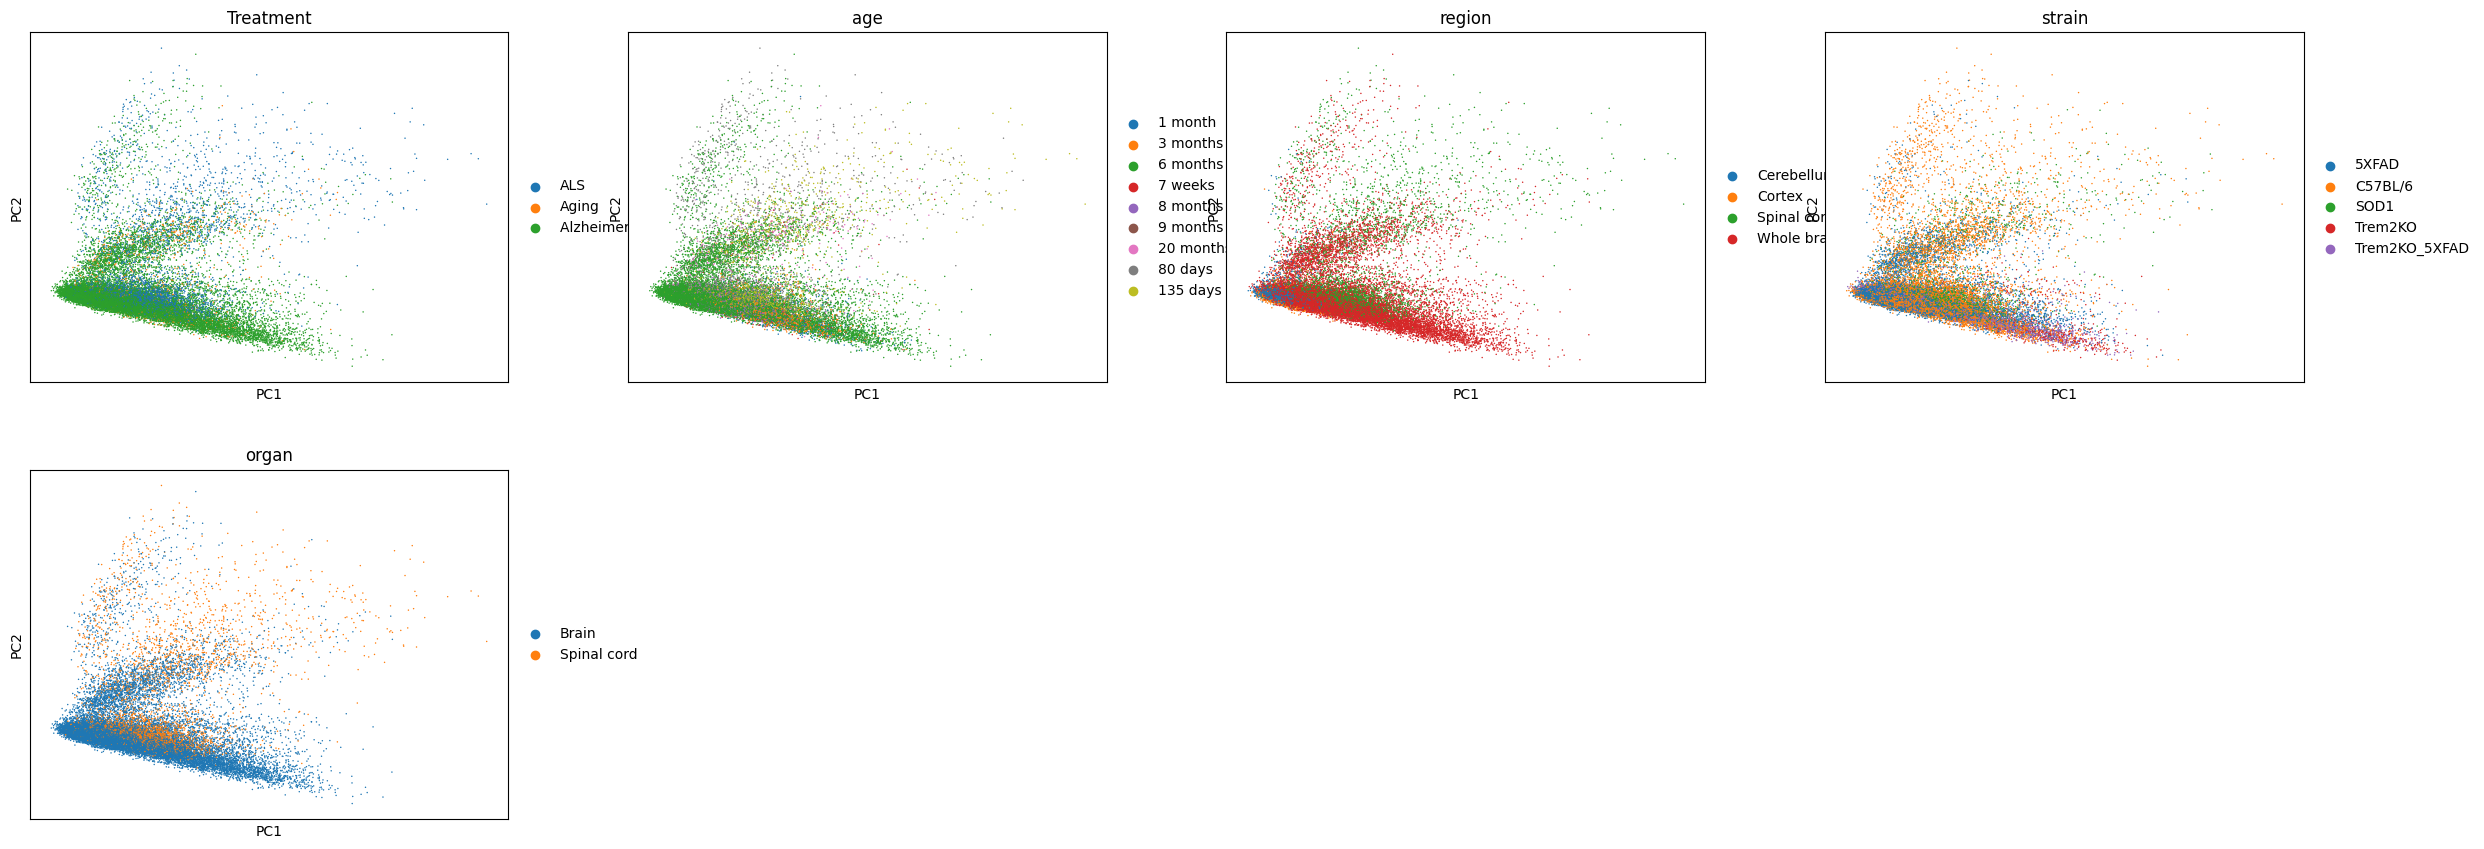

In [79]:
# Plot PCA results
sc.pl.pca(adata, color=['Treatment', 'age', 'region', 'strain', 'organ'])

In [76]:
# Compute neighborhood graph

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Perform UMAP Embedding
sc.tl.umap(adata)

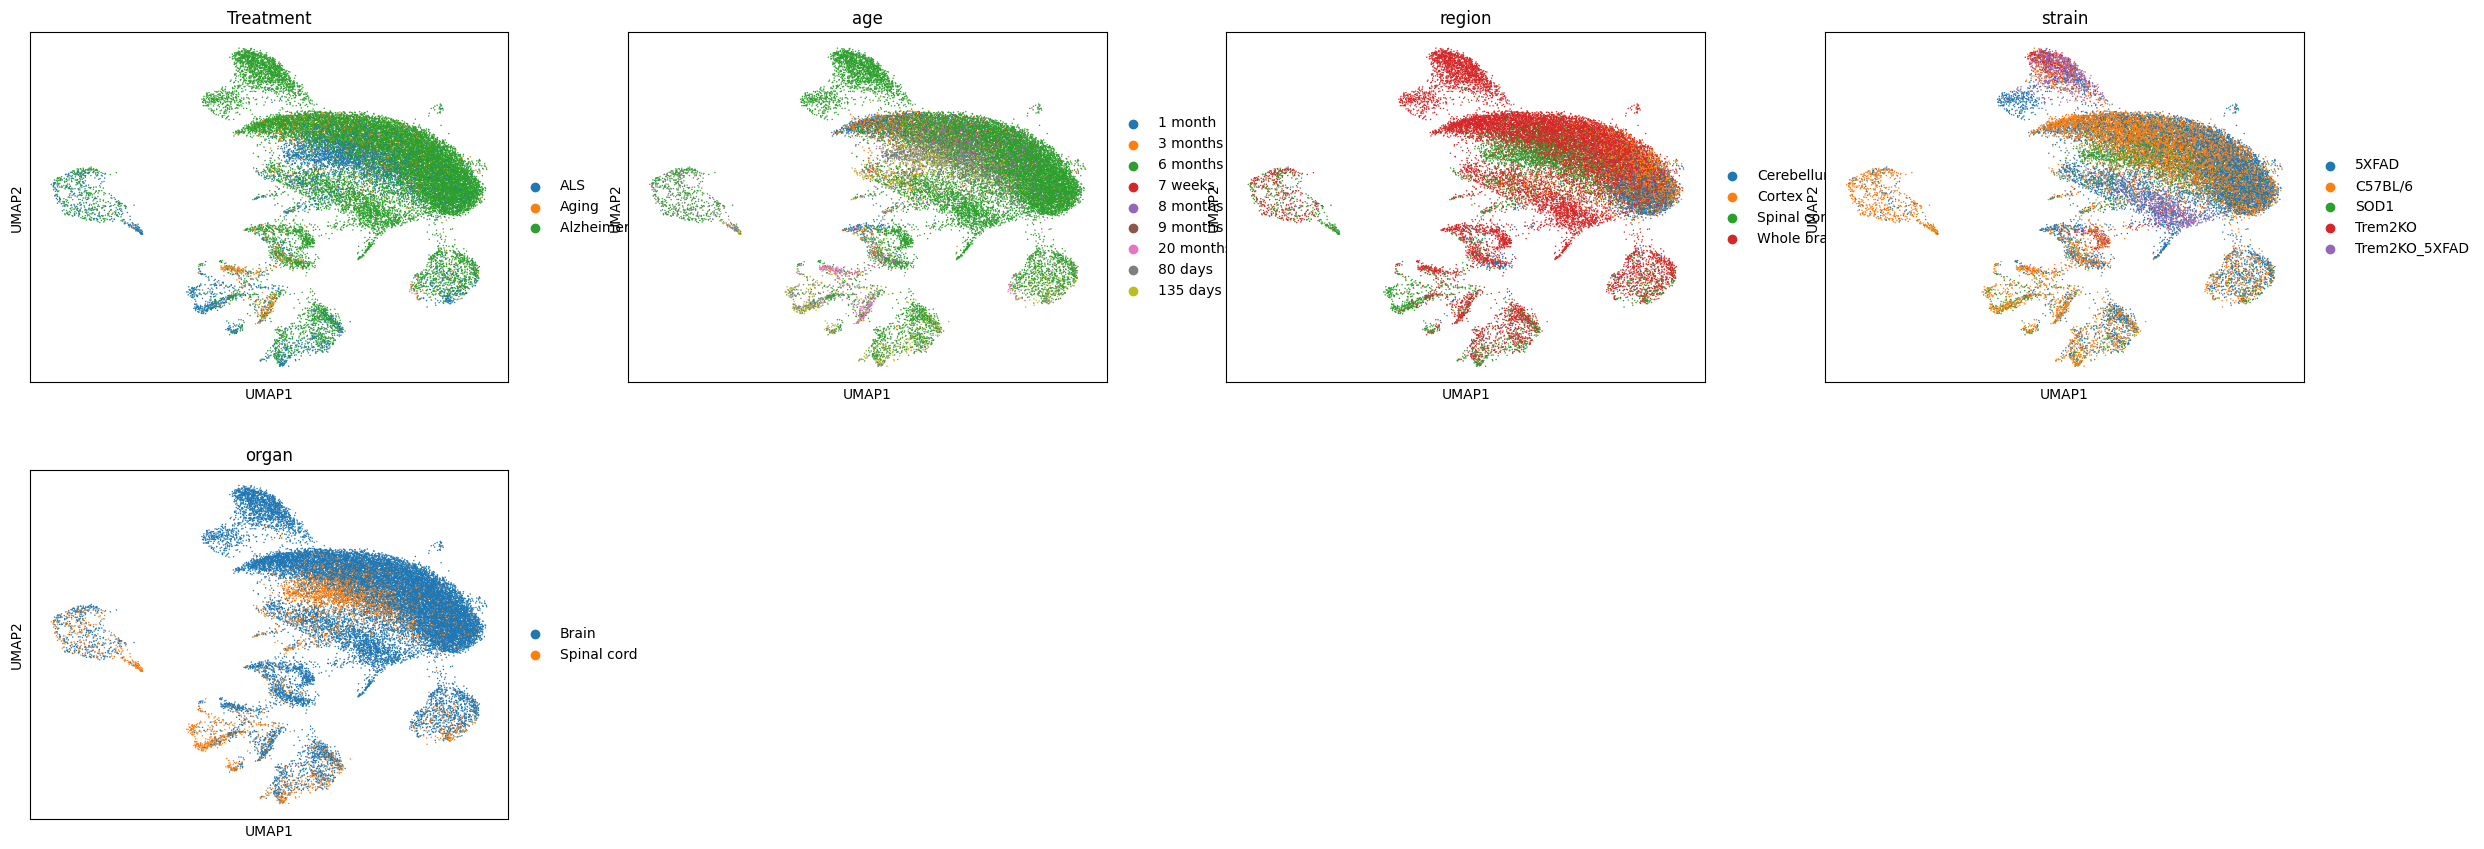

In [77]:
# Plot UMAP
sc.pl.umap(adata, color=['Treatment', 'age', 'region', 'strain', 'organ'])

In [80]:
# Perform clustering
sc.tl.leiden(adata)

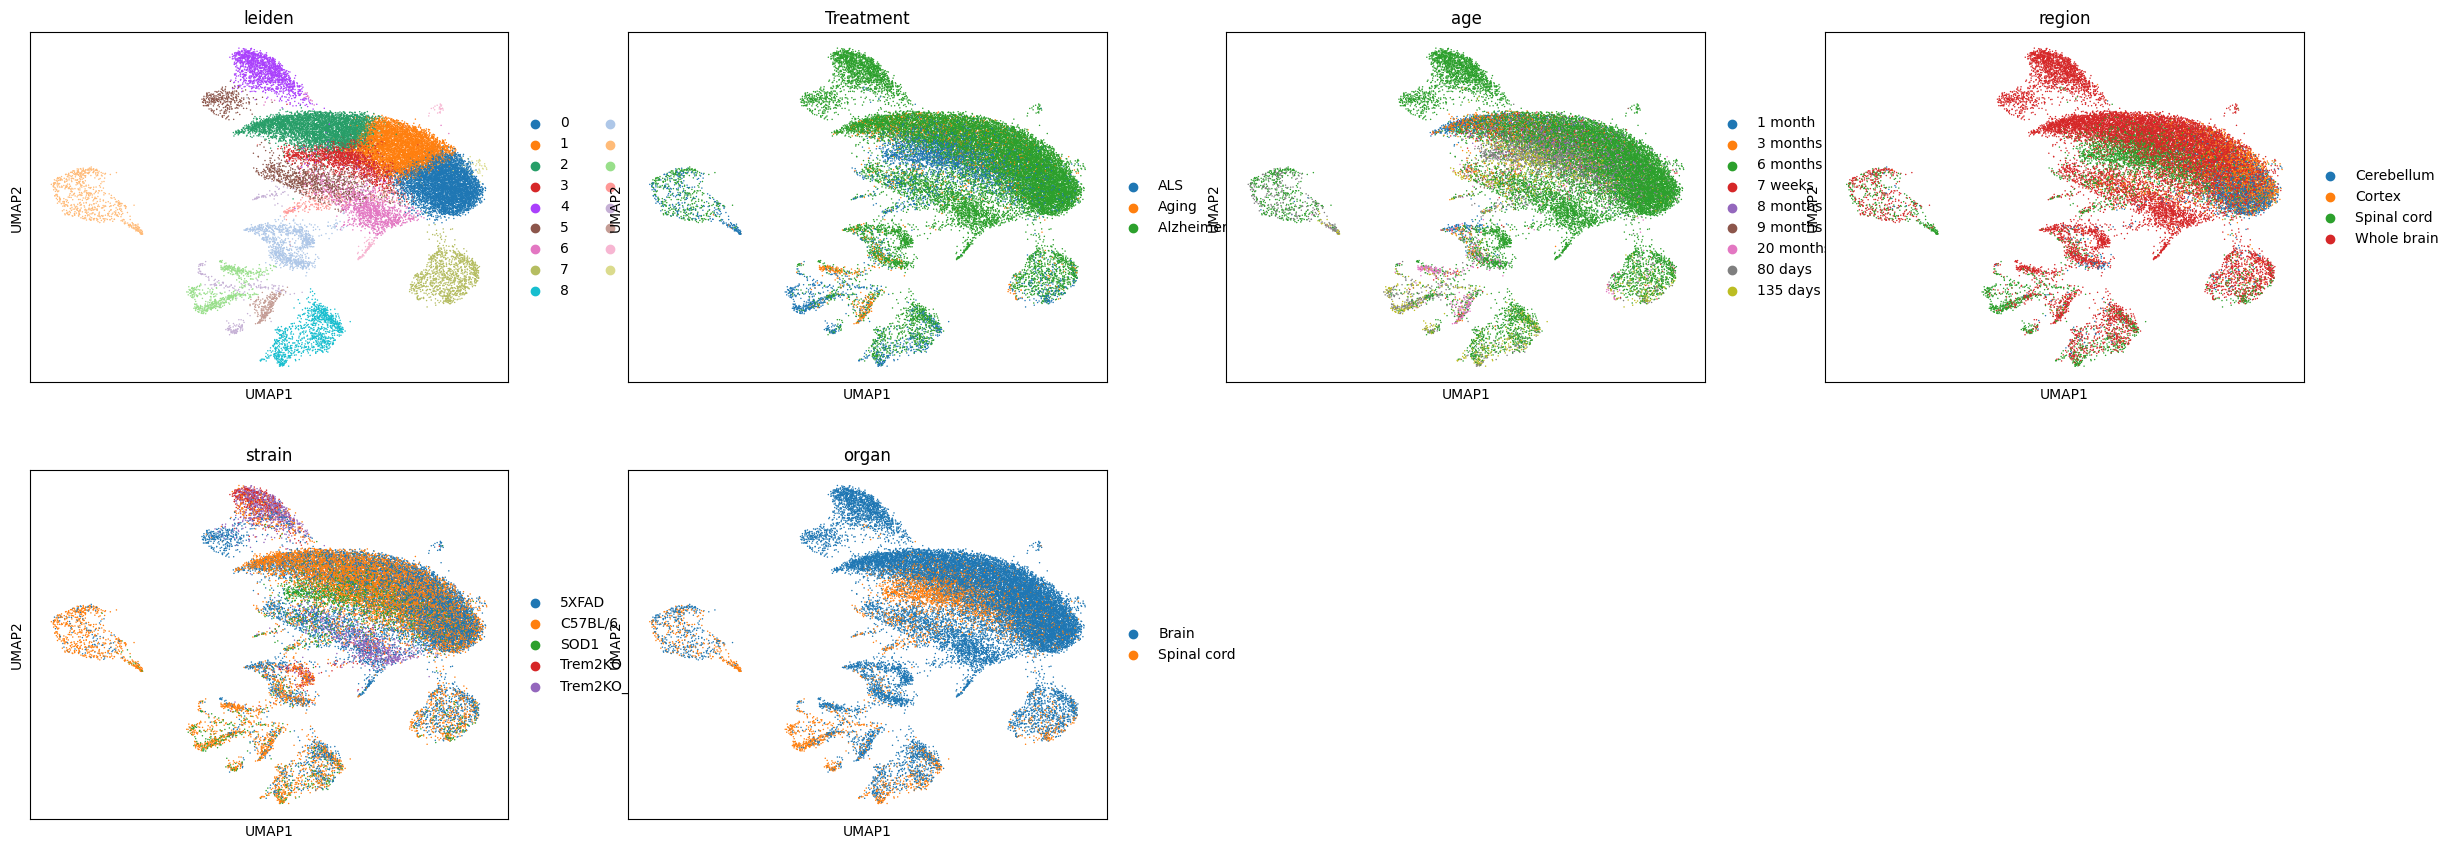

In [81]:
# Plot clustering results
sc.pl.umap(adata, color=['leiden', 'Treatment', 'age', 'region', 'strain', 'organ'])

In [82]:
%%capture
# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

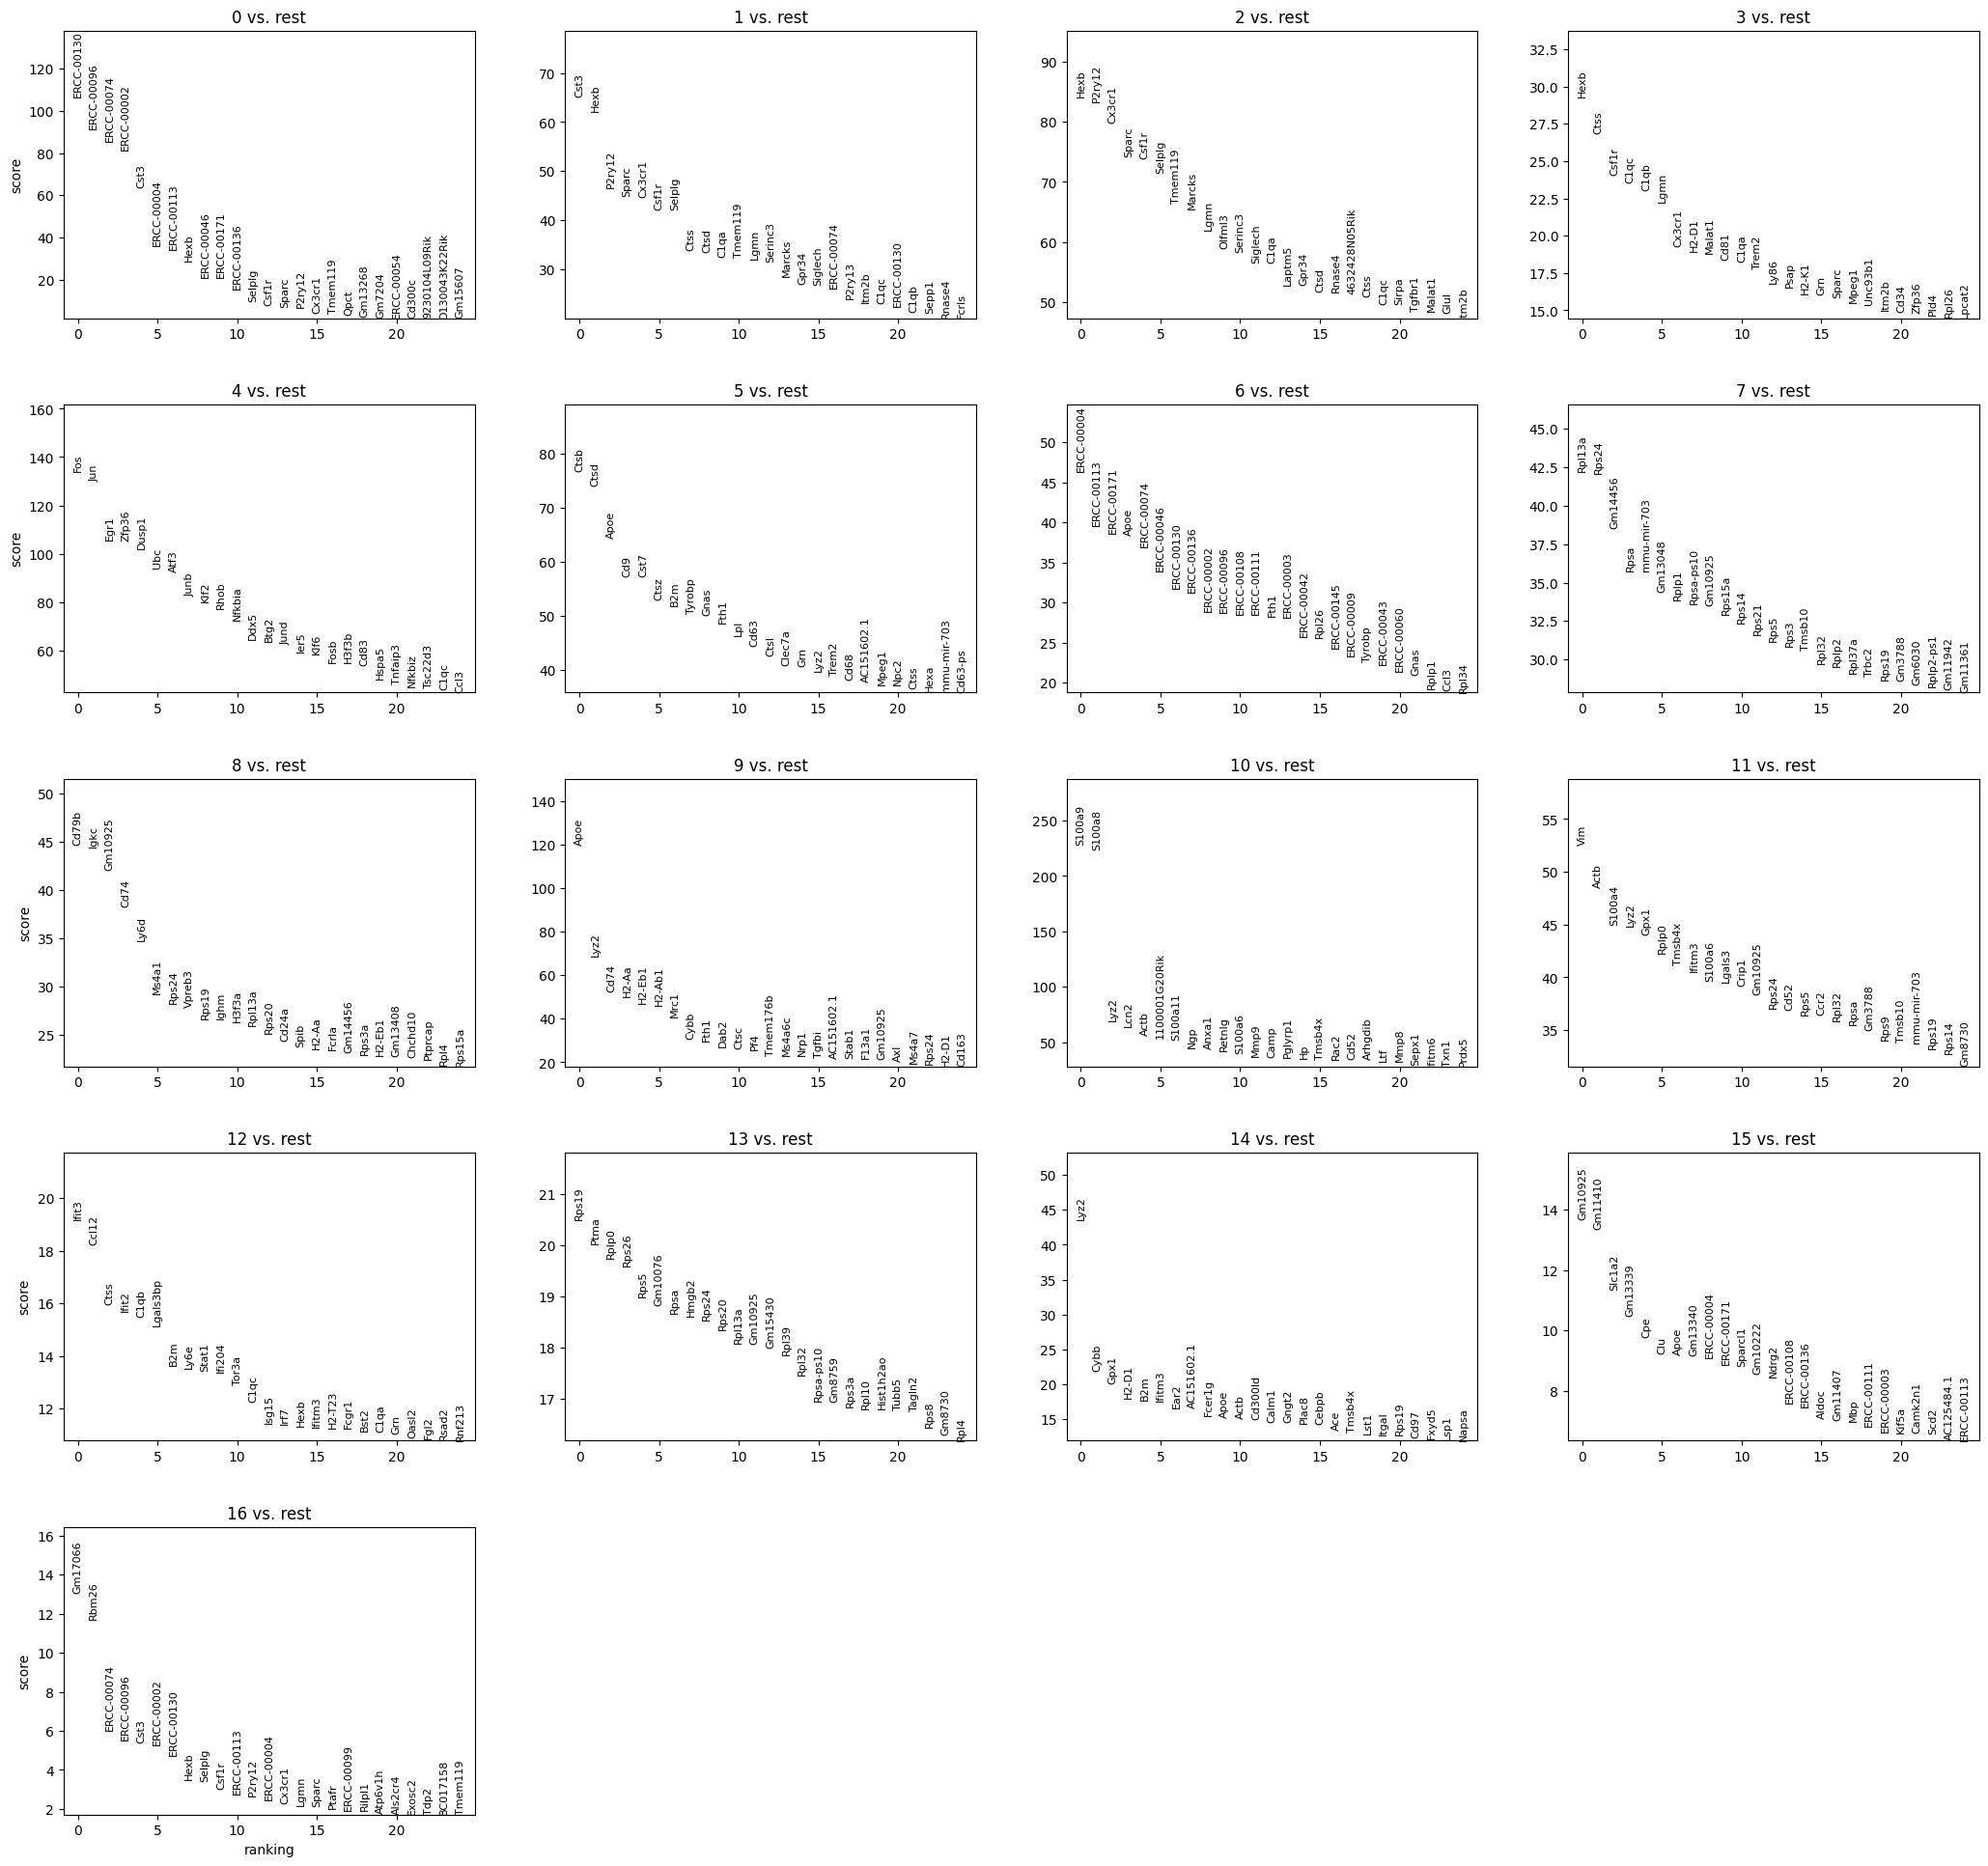

In [83]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [84]:
# Save the results
adata.write('./output/GSE98969_microglia_results.h5ad')

print("Analysis complete. Results saved to 'GSE98969_microglia_results.h5ad'.")

Analysis complete. Results saved to 'GSE98969_microglia_results.h5ad'.


In [ ]:
# Load the saved data back
adata_loaded = sc.read('./output/GSE98969_microglia_results.h5ad')

In [89]:
adata.X

array([[-0.02312289, -0.34615865, -0.22743857, ..., -0.02695376,
        -0.03764517, -0.04963206],
       [-0.02312289, -0.34615865, -0.22743857, ..., -0.02695376,
        -0.03764517, -0.04963206],
       [-0.02312289, -0.34615865, -0.22743857, ..., -0.02695376,
        -0.03764517, -0.04963206],
       ...,
       [-0.02312289, -0.34615865, -0.22743857, ..., -0.02695376,
        -0.03764517, -0.04963206],
       [-0.02312289, -0.34615865, -0.22743857, ..., -0.02695376,
        -0.03764517, -0.04963206],
       [-0.02312289, -0.34615865, -0.22743857, ..., -0.02695376,
        -0.03764517, -0.04963206]], dtype=float32)

In [93]:
adata

AnnData object with n_obs × n_vars = 27117 × 19043
    obs: 'Treatment', 'age', 'region', 'title', 'strain', 'organ', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Treatment_colors', 'age_colors', 'region_colors', 'strain_colors', 'organ_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [96]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns

# Create a count matrix from the AnnData object
# We need to use the raw counts, not the normalized data
if 'counts' in adata.layers:
    count_matrix = pd.DataFrame(adata.layers['counts'], index=adata.obs_names, columns=adata.var_names)
else:
    print("Warning: Raw counts not found. Using data from adata.X")
    count_matrix = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

print(count_matrix.head())

# Ensure all values are non-negative integers
count_matrix = count_matrix.clip(lower=0).astype(int)

# Create a sample information dataframe
sample_info = adata.obs[['strain']].copy()
sample_info.columns = ['condition']

print(f"Number of samples (cells) in count matrix: {count_matrix.shape[0]}")
print(f"Number of genes in count matrix: {count_matrix.shape[1]}")
print(f"Number of samples in sample info: {len(sample_info)}")

# Create DeseqDataSet object
dds = DeseqDataSet(
    counts=count_matrix,
    metadata=sample_info,
    design_factors="condition",
    refit_cooks=True
)

# Run DESeq2 analysis
dds.deseq2()

# Get results
# Assuming you want to compare 5XFAD to C57BL/6
stat_res = DeseqStats(dds, contrast=["condition", "5XFAD", "C57BL/6"])
stat_res.summary()
results = stat_res.results_df

# Filter for significantly differentially expressed genes
significant_genes = results[(results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1)]

print(f"Number of significantly differentially expressed genes: {len(significant_genes)}")

# Save results to CSV
results.to_csv('deseq2_results_strain_comparison.csv')
significant_genes.to_csv('deseq2_significant_genes_strain_comparison.csv')

# Create a volcano plot
plt.figure(figsize=(10, 8))
results['-log10_pvalue'] = -np.log10(results['pvalue'])
sns.scatterplot(data=results, x='log2FoldChange', y='-log10_pvalue', 
                hue=(results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1))
plt.title('Volcano Plot of DESeq2 Results: 5XFAD vs C57BL/6')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.savefig('deseq2_volcano_plot_strain_comparison.png')
plt.close()

print("DESeq2 analysis complete. Results saved to 'deseq2_results_strain_comparison.csv' and 'deseq2_significant_genes_strain_comparison.csv'.")
print("Volcano plot saved as 'deseq2_volcano_plot_strain_comparison.png'.")

Number of samples (cells) in count matrix: 27117
Number of genes in count matrix: 19043
Number of samples in sample info: 27117


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 11.30 seconds.

Fitting dispersions...
... done in 65.18 seconds.

Fitting dispersion trend curve...
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pydeseq2/dds.py:715: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 66.02 seconds.

Fitting LFCs...
... done in 43.37 seconds.

Calculating cook's distance...
... done in 84.42 seconds.

Replacing 21 outlier genes.

Fitting dispersions...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 1.17 seconds.

Fitting LFCs...


Log2 fold change & Wald test p-value: condition 5XFAD vs C57BL/6
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik  0.000977       -0.189369  2.427779 -0.078001  0.937827   
0610007C21Rik  0.218713       -0.064752  0.076116 -0.850704  0.394934   
0610007L01Rik  0.104792       -0.165666  0.133090 -1.244767  0.213217   
0610007P08Rik  0.025345       -0.185198  0.351280 -0.527210  0.598048   
0610007P14Rik  0.047090       -0.202806  0.222380 -0.911981  0.361779   
...                 ...             ...       ...       ...       ...   
snoU89         0.006329       -0.182685  0.737900 -0.247574  0.804464   
snoU90         0.014720       -0.197281  0.427190 -0.461810  0.644217   
snoU97         0.000956       -0.194514  2.033546 -0.095653  0.923796   
snoZ39         0.002681       -0.195847  1.334379 -0.146770  0.883313   
snoZ40         0.004799       -0.194778  0.950381 -0.204947  0.837614   

                   padj  
0610005C13Rik       NaN  
061000

In [34]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def load_data(file_path):
    """Load the saved results."""
    adata = sc.read(file_path)
    print(f"Data loaded successfully. Shape: {adata.shape}")
    print(f"Observations: {list(adata.obs_keys())}")
    print(f"Variables: {list(adata.var_keys())}")
    return adata

def prepare_data(adata):
    """Prepare the data for analysis."""
    adata.layers['log_norm'] = adata.X.copy()
    adata.X = adata.layers['counts'].copy()
    return adata

def create_pseudobulk(adata, group_by):
    """Create pseudo-bulk data from single-cell data."""
    adata.obs[group_by] = pd.Categorical(adata.obs[group_by])
    indicator = pd.get_dummies(adata.obs[group_by])
    
    pseudobulk = ad.AnnData(
        X=indicator.values.T @ adata.X,
        obs=pd.DataFrame(index=indicator.columns),
        var=adata.var.copy()
    )
    
    pseudobulk.obs = adata.obs.groupby(group_by).first()
    
    for layer in adata.layers.keys():
        pseudobulk.layers[layer] = indicator.values.T @ adata.layers[layer]
    
    return pseudobulk

def normalize_pseudobulk(pseudobulk):
    """Normalize pseudo-bulk data."""
    pseudobulk_norm = pseudobulk.copy()
    pseudobulk_norm.X = pseudobulk_norm.X / pseudobulk_norm.X.sum(axis=1, keepdims=True) * 1e6
    pseudobulk_norm.layers['counts'] = pseudobulk_norm.layers['counts'] / pseudobulk_norm.layers['counts'].sum(axis=1, keepdims=True) * 1e6
    pseudobulk_norm.layers['log_norm'] = np.log1p(pseudobulk_norm.X)
    return pseudobulk_norm

def log_transform(pseudobulk_norm):
    """Log transform the normalized data."""
    pseudobulk_log = pseudobulk_norm.copy()
    pseudobulk_log.X = np.log2(pseudobulk_log.X + 1)
    return pseudobulk_log

def perform_de(adata, group1, group2, min_samples=3):
    """
    Perform differential expression analysis.
    
    Parameters:
    - adata: AnnData object
    - group1, group2: lists of sample names for each group
    - min_samples: minimum number of samples required in each group to perform t-test
    """
    genes = []
    pvalues = []
    log2fc = []
    
    for gene in adata.var_names:
        group1_data = adata[:, gene].X[adata.obs.index.isin(group1)].flatten()
        group2_data = adata[:, gene].X[adata.obs.index.isin(group2)].flatten()
        
        # Remove zero values
        group1_data = group1_data[group1_data != 0]
        group2_data = group2_data[group2_data != 0]
        
        # Check if we have enough non-zero samples
        if len(group1_data) >= min_samples and len(group2_data) >= min_samples:
            # Perform t-test
            t_stat, p_value = stats.ttest_ind(group1_data, group2_data)
            
            # Calculate log2 fold change
            mean1 = np.mean(group1_data) if len(group1_data) > 0 else 1e-9
            mean2 = np.mean(group2_data) if len(group2_data) > 0 else 1e-9
            log2fc_value = np.log2(mean1 / mean2)
            
            genes.append(gene)
            pvalues.append(p_value)
            log2fc.append(log2fc_value)
        else:
            # If not enough samples, add NaN values
            genes.append(gene)
            pvalues.append(np.nan)
            log2fc.append(np.nan)
    
    return pd.DataFrame({'gene': genes, 'pvalue': pvalues, 'log2fc': log2fc})

def plot_volcano(de_results):
    """Create and save a volcano plot."""
    plt.figure(figsize=(10, 8))
    plt.scatter(de_results['log2fc'], -np.log10(de_results['pvalue']), alpha=0.5)
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 P-value')
    plt.title('Volcano Plot: 5XFAD vs C57BL/6')
    plt.show()

def plot_heatmap(adata, genes):
    """Create and save a heatmap of top differentially expressed genes."""
    plt.figure(figsize=(12, 10))
    sc.pl.heatmap(adata, var_names=genes, groupby='strain', show_gene_labels=True, cmap='viridis', dendrogram=False)
    plt.show()
    

def save_results(pseudobulk, pseudobulk_norm, pseudobulk_log, de_results):
    """Save analysis results to CSV files."""
    pseudobulk.write_csvs('pseudobulk_raw_counts.csv')
    pseudobulk_norm.write_csvs('pseudobulk_normalized.csv')
    pd.DataFrame(pseudobulk_log.X.T, index=pseudobulk_log.var_names, columns=pseudobulk_log.obs_names).to_csv('pseudobulk_log_transformed.csv')
    de_results.to_csv('differential_expression_results.csv')


In [35]:
# Load and prepare data
adata = load_data('./output/GSE98969_microglia_results.h5ad')

Data loaded successfully. Shape: (27117, 19043)
Observations: ['Treatment', 'age', 'region', 'title', 'strain', 'organ', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden']
Variables: ['n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std']


In [36]:
adata

AnnData object with n_obs × n_vars = 27117 × 19043
    obs: 'Treatment', 'age', 'region', 'title', 'strain', 'organ', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Treatment_colors', 'age_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'organ_colors', 'pca', 'rank_genes_groups', 'region_colors', 'strain_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [37]:
adata = prepare_data(adata)

In [38]:
# Create and process pseudo-bulk data
pseudobulk = create_pseudobulk(adata, 'strain')
pseudobulk_norm = normalize_pseudobulk(pseudobulk)
pseudobulk_log = log_transform(pseudobulk_norm)

/beegfs/scratch/tmp/ipykernel_21326/1504781581.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk.obs = adata.obs.groupby(group_by).first()
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:747: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['5XFAD', 'C57BL/6', 'SOD1', 'Trem2KO', 'Trem2KO_5XFAD']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [39]:
# Perform differential expression analysis
de_results = perform_de(pseudobulk_log, ['5XFAD'], ['C57BL/6'])
de_results = de_results.sort_values('pvalue')

In [40]:
de_results

,gene,pvalue,log2fc
0,0610005C13Rik,NaN,NaN
1,0610007C21Rik,NaN,NaN
2,0610007L01Rik,NaN,NaN
3,0610007P08Rik,NaN,NaN
4,0610007P14Rik,NaN,NaN
...,...,...,...
19038,snoU89,NaN,NaN
19039,snoU90,NaN,NaN
19040,snoU97,NaN,NaN
19041,snoZ39,NaN,NaN


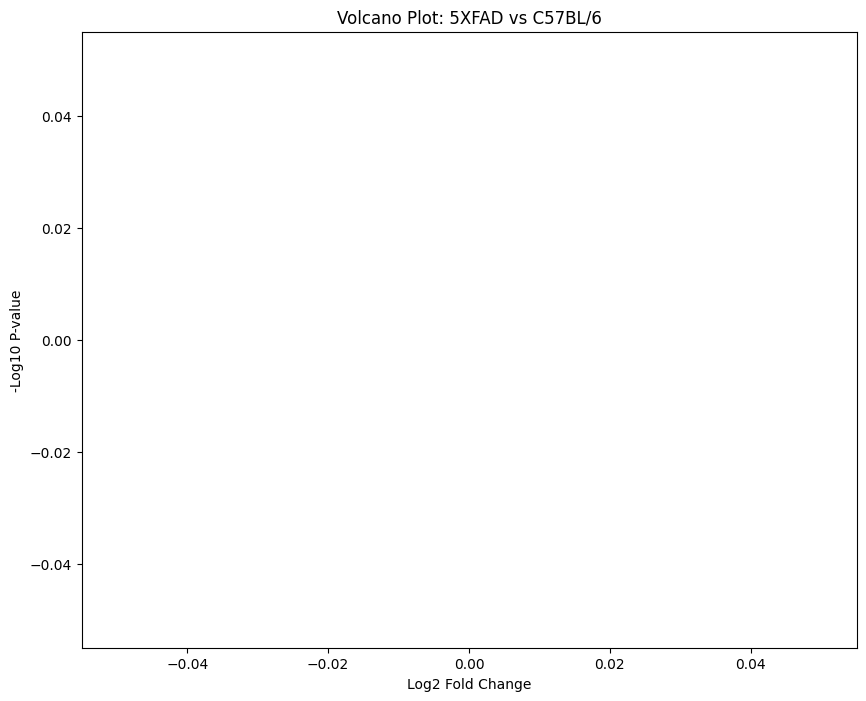

In [41]:
plot_volcano(de_results)

In [42]:
# plot_heatmap(pseudobulk_log, de_results.head(50)['gene'])

In [43]:
# Create pseudo-bulk data
def create_pseudobulk(adata, group_by):
    """
    This function creates pseudo-bulk data from single-cell data.
    
    Parameters:
    - adata: AnnData object containing single-cell data
    - group_by: String, the column name in adata.obs to group cells by
    
    The function does the following:
    1. Converts the grouping column to categorical data type.
    2. Creates an indicator matrix for each group.
    3. Sums the counts for each group to create pseudo-bulk data.
    4. Maintains relevant metadata from the original data.
    5. Preserves all layers from the original data in the pseudo-bulk data.
    
    Returns:
    - pseudobulk: AnnData object containing the pseudo-bulk data
    """
    # Convert group_by column to categorical if it's not already
    adata.obs[group_by] = pd.Categorical(adata.obs[group_by])
    
    # Create indicator matrix
    indicator = pd.get_dummies(adata.obs[group_by])
    
    # Sum the counts for each group
    pseudobulk = ad.AnnData(
        X=indicator.values.T @ adata.X,
        obs=pd.DataFrame(index=indicator.columns),
        var=adata.var.copy()
    )
    
    # Maintain relevant metadata
    pseudobulk.obs = adata.obs.groupby(group_by).first()
    
    # Ensure the layers are preserved
    for layer in adata.layers.keys():
        pseudobulk.layers[layer] = indicator.values.T @ adata.layers[layer]
    
    return pseudobulk

In [44]:
pseudobulk = create_pseudobulk(adata, 'strain')

/beegfs/scratch/tmp/ipykernel_21326/889158377.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk.obs = adata.obs.groupby(group_by).first()
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:747: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['5XFAD', 'C57BL/6', 'SOD1', 'Trem2KO', 'Trem2KO_5XFAD']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [45]:
pseudobulk

AnnData object with n_obs × n_vars = 5 × 19043
    obs: 'Treatment', 'age', 'region', 'title', 'organ', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    layers: 'counts', 'log_norm'

In [46]:
pseudobulk.X

array([[  17, 2163,  933, ...,    6,   14,   24],
       [   4, 2124, 1010, ...,   12,   27,   35],
       [   1,  294,  161, ...,    2,    5,   11],
       [   3,  246,  106, ...,    1,    2,    2],
       [   1,  364,  174, ...,    2,   11,    7]])

In [47]:
# # Normalize pseudo-bulk data
# pseudobulk_norm = pseudobulk.copy()
# pseudobulk_norm.X = pseudobulk_norm.X / pseudobulk_norm.X.sum(axis=1, keepdims=True) * 1e6  # CPM normalization
# pseudobulk_norm.layers['counts'] = pseudobulk_norm.layers['counts'] / pseudobulk_norm.layers['counts'].sum(axis=1, keepdims=True) * 1e6  # CPM normalization for counts layer
# pseudobulk_norm.layers['log_norm'] = np.log1p(pseudobulk_norm.X)  # Log-normalize the main matrix
# pseudobulk_norm.X

In [49]:
# Log transform
pseudobulk_log = np.log2(pseudobulk_norm + 1)

TypeError: unsupported operand type(s) for +: 'AnnData' and 'int'

In [ ]:
pseudobulk_log.head()

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('pseudobulk_log.tsv', sep='\t', index_col=0)

# Create AnnData object
adata = sc.AnnData(data.T)

# Add gene names to var
adata.var_names = data.index

# Add condition information to obs
adata.obs['condition'] = adata.obs.index

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, 'condition', method='wilcoxon')

# Get results
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names

# Create a DataFrame with the results
def get_df(key):
    return pd.DataFrame({group + '_' + key: results[key][group] for group in groups})

results_df = pd.concat([get_df(key) for key in ['names', 'scores', 'pvals', 'pvals_adj']], axis=1)

# Save results to CSV
results_df.to_csv('differential_expression_results.csv')

# Visualize top differentially expressed genes
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
plt.savefig('top_differentially_expressed_genes.png')

# Create a heatmap of top differentially expressed genes
top_genes = results_df.iloc[:50, results_df.columns.get_level_values(1)=='names'].values.flatten()
sc.pl.heatmap(adata, top_genes, groupby='condition', show_gene_labels=True, figsize=(12, 8))
plt.savefig('heatmap_top_differentially_expressed_genes.png')

print("Differential expression analysis completed. Results saved to 'differential_expression_results.csv'")
print("Visualizations saved as 'top_differentially_expressed_genes.png' and 'heatmap_top_differentially_expressed_genes.png'")

In [ ]:
# Perform differential expression analysis
def perform_de(data, group1, group2):
    genes = []
    pvalues = []
    log2fc = []
    for gene in data.index:
        t_stat, p_value = stats.ttest_ind(data.loc[gene, group1], data.loc[gene, group2])
        genes.append(gene)
        pvalues.append(p_value)
        log2fc.append(np.log2(data.loc[gene, group1].mean() / data.loc[gene, group2].mean()))
    return pd.DataFrame({'gene': genes, 'pvalue': pvalues, 'log2fc': log2fc})


In [ ]:
# Example: Differential expression between 5XFAD and C57BL/6
de_results = perform_de(pseudobulk_log, ['5XFAD'], ['C57BL/6'])
de_results = de_results.sort_values('pvalue')

In [ ]:
de_results.head()

In [ ]:
# Volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(de_results['log2fc'], -np.log10(de_results['pvalue']), alpha=0.5)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.title('Volcano Plot: 5XFAD vs C57BL/6')
plt.show()

# Heatmap of top differentially expressed genes
top_genes = de_results.head(50)['gene']
plt.figure(figsize=(12, 10))
sns.heatmap(pseudobulk_log.loc[top_genes], cmap='viridis', center=0)
plt.title('Top 50 Differentially Expressed Genes')
plt.show()

# Save pseudo-bulk data
pseudobulk.to_csv('pseudobulk_raw_counts.csv')
pseudobulk_norm.to_csv('pseudobulk_normalized.csv')
pseudobulk_log.to_csv('pseudobulk_log_transformed.csv')
de_results.to_csv('differential_expression_results.csv')

print("Pseudo-bulk analysis complete. Results saved to CSV files and plots.")